In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import FastICA
from pandas import DataFrame, Series
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import io

%matplotlib inline
np.set_printoptions(precision=3 , suppress= True)

In [2]:
#importing the file and defining the columns I am going to work with:
filePath = './pord.txt'
columnsName = ['YYMMMDD', '__east(m)', 'sig_e(m)']
site = pd.read_csv(filePath, usecols = columnsName, delimiter = '\s+')
site

,YYMMMDD,__east(m),sig_e(m)
0,06AUG25,-0.516736,0.000751
1,06AUG26,-0.517955,0.000740
2,06AUG27,-0.518386,0.000759
3,06AUG28,-0.516901,0.000740
4,06AUG29,-0.518053,0.000752
...,...,...,...
5869,22DEC27,-0.175921,0.000666
5870,22DEC28,-0.178189,0.000676
5871,22DEC29,-0.176989,0.000645
5872,22DEC30,-0.178170,0.000640


In [3]:
#changing the dtype of 'YYMMMDD':
site['YYMMMDD'] = pd.to_datetime(site['YYMMMDD'], format='%y%b%d')
site['YYMMMDD']

0      2006-08-25
1      2006-08-26
2      2006-08-27
3      2006-08-28
4      2006-08-29
          ...    
5869   2022-12-27
5870   2022-12-28
5871   2022-12-29
5872   2022-12-30
5873   2022-12-31
Name: YYMMMDD, Length: 5874, dtype: datetime64[ns]

In [4]:
#setting 'YYMMMDD' as index:
site.set_index('YYMMMDD', inplace = True)
site

,__east(m),sig_e(m)
YYMMMDD,,
2006-08-25,-0.516736,0.000751
2006-08-26,-0.517955,0.000740
2006-08-27,-0.518386,0.000759
2006-08-28,-0.516901,0.000740
2006-08-29,-0.518053,0.000752
...,...,...
2022-12-27,-0.175921,0.000666
2022-12-28,-0.178189,0.000676
2022-12-29,-0.176989,0.000645


In [5]:
#creating a new instance with a new period for the time series:
sitePeriodTime = site.loc['2006-08-25':'2022-12-31']
sitePeriodTime

,__east(m),sig_e(m)
YYMMMDD,,
2006-08-25,-0.516736,0.000751
2006-08-26,-0.517955,0.000740
2006-08-27,-0.518386,0.000759
2006-08-28,-0.516901,0.000740
2006-08-29,-0.518053,0.000752
...,...,...
2022-12-27,-0.175921,0.000666
2022-12-28,-0.178189,0.000676
2022-12-29,-0.176989,0.000645


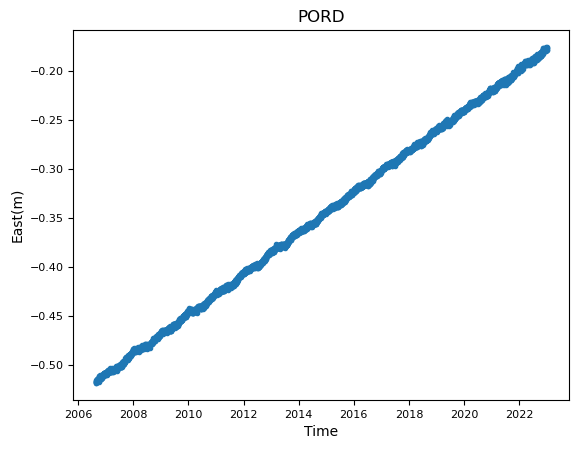

In [6]:
#checking the if the ts is stationarity for east:
plt.plot(sitePeriodTime.index, sitePeriodTime['__east(m)'], '.')
plt.title('PORD')
plt.xlabel('Time')
plt.xticks(fontsize=8)
plt.ylabel('East(m)')
plt.yticks(fontsize=8)
plt.show()

In [7]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    rolstd = pd.Series(timeseries).rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

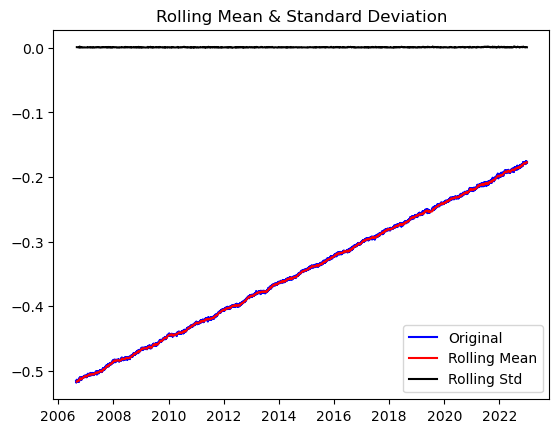

Results of Dickey-Fuller Test:
Test Statistic                    0.134965
p-value                           0.968369
#Lags Used                       15.000000
Number of Observations Used    5858.000000
Critical Value (1%)              -3.431467
Critical Value (5%)              -2.862034
Critical Value (10%)             -2.567033
dtype: float64


In [8]:
test_stationarity(sitePeriodTime['__east(m)'])

In [9]:
tsLogE = np.log1p(sitePeriodTime['__east(m)'])
tsLogE

YYMMMDD
2006-08-25   -0.727192
2006-08-26   -0.729718
2006-08-27   -0.730612
2006-08-28   -0.727534
2006-08-29   -0.729921
                ...   
2022-12-27   -0.193489
2022-12-28   -0.196245
2022-12-29   -0.194786
2022-12-30   -0.196222
2022-12-31   -0.194697
Name: __east(m), Length: 5874, dtype: float64

In [10]:
tsLogE_df = pd.DataFrame(tsLogE, index=tsLogE.index)
tsLogE_df

,__east(m)
YYMMMDD,
2006-08-25,-0.727192
2006-08-26,-0.729718
2006-08-27,-0.730612
2006-08-28,-0.727534
2006-08-29,-0.729921
...,...
2022-12-27,-0.193489
2022-12-28,-0.196245
2022-12-29,-0.194786


In [11]:
tsLogDiffE = tsLogE - tsLogE.shift()
tsLogDiffE

YYMMMDD
2006-08-25         NaN
2006-08-26   -0.002526
2006-08-27   -0.000895
2006-08-28    0.003079
2006-08-29   -0.002387
                ...   
2022-12-27    0.001407
2022-12-28   -0.002756
2022-12-29    0.001459
2022-12-30   -0.001436
2022-12-31    0.001525
Name: __east(m), Length: 5874, dtype: float64

In [12]:
tsLogDiffE.dropna(inplace = True)
tsLogDiffE

YYMMMDD
2006-08-26   -0.002526
2006-08-27   -0.000895
2006-08-28    0.003079
2006-08-29   -0.002387
2006-08-30    0.005116
                ...   
2022-12-27    0.001407
2022-12-28   -0.002756
2022-12-29    0.001459
2022-12-30   -0.001436
2022-12-31    0.001525
Name: __east(m), Length: 5873, dtype: float64

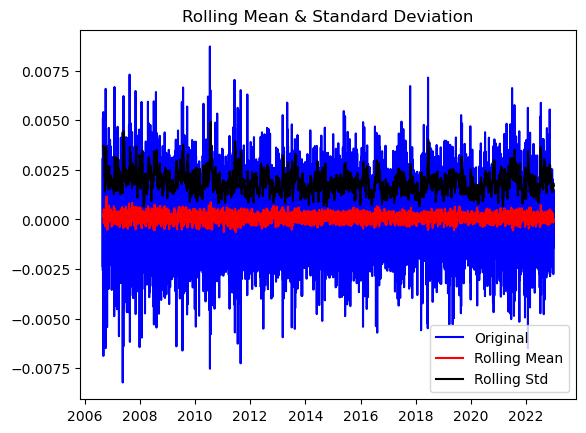

Results of Dickey-Fuller Test:
Test Statistic                  -28.127442
p-value                           0.000000
#Lags Used                       14.000000
Number of Observations Used    5858.000000
Critical Value (1%)              -3.431467
Critical Value (5%)              -2.862034
Critical Value (10%)             -2.567033
dtype: float64


In [13]:
test_stationarity(tsLogDiffE)

In [14]:
tsLogDiffE_df = pd.DataFrame(tsLogDiffE, index=tsLogDiffE.index)
tsLogDiffE_df

,__east(m)
YYMMMDD,
2006-08-26,-0.002526
2006-08-27,-0.000895
2006-08-28,0.003079
2006-08-29,-0.002387
2006-08-30,0.005116
...,...
2022-12-27,0.001407
2022-12-28,-0.002756
2022-12-29,0.001459


In [15]:
limiarZ = 1.0
tsLogDiffE_noOut = tsLogDiffE_df[(np.abs(tsLogDiffE_df-tsLogDiffE_df.mean()) 
                                              < limiarZ*tsLogDiffE_df.std())]
tsLogDiffE_noOut

,__east(m)
YYMMMDD,
2006-08-26,NaN
2006-08-27,-0.000895
2006-08-28,NaN
2006-08-29,NaN
2006-08-30,NaN
...,...
2022-12-27,0.001407
2022-12-28,NaN
2022-12-29,0.001459


In [16]:
#removing the rows with missing values
tsLogDiffE_noOut.dropna(inplace=True)
tsLogDiffE_noOut

,__east(m)
YYMMMDD,
2006-08-27,-0.000895
2006-09-01,-0.000099
2006-09-02,-0.000926
2006-09-07,-0.001310
2006-09-08,-0.001602
...,...
2022-12-26,-0.001059
2022-12-27,0.001407
2022-12-29,0.001459


#making a copy of the data 
tsLogDiffE_noOut2= tsLogDiffE_noOut

#replacing the missing values for the mean
tsLogDiffE_noOut2.fillna(tsLogDiffE_noOut2.mean(), inplace = True)

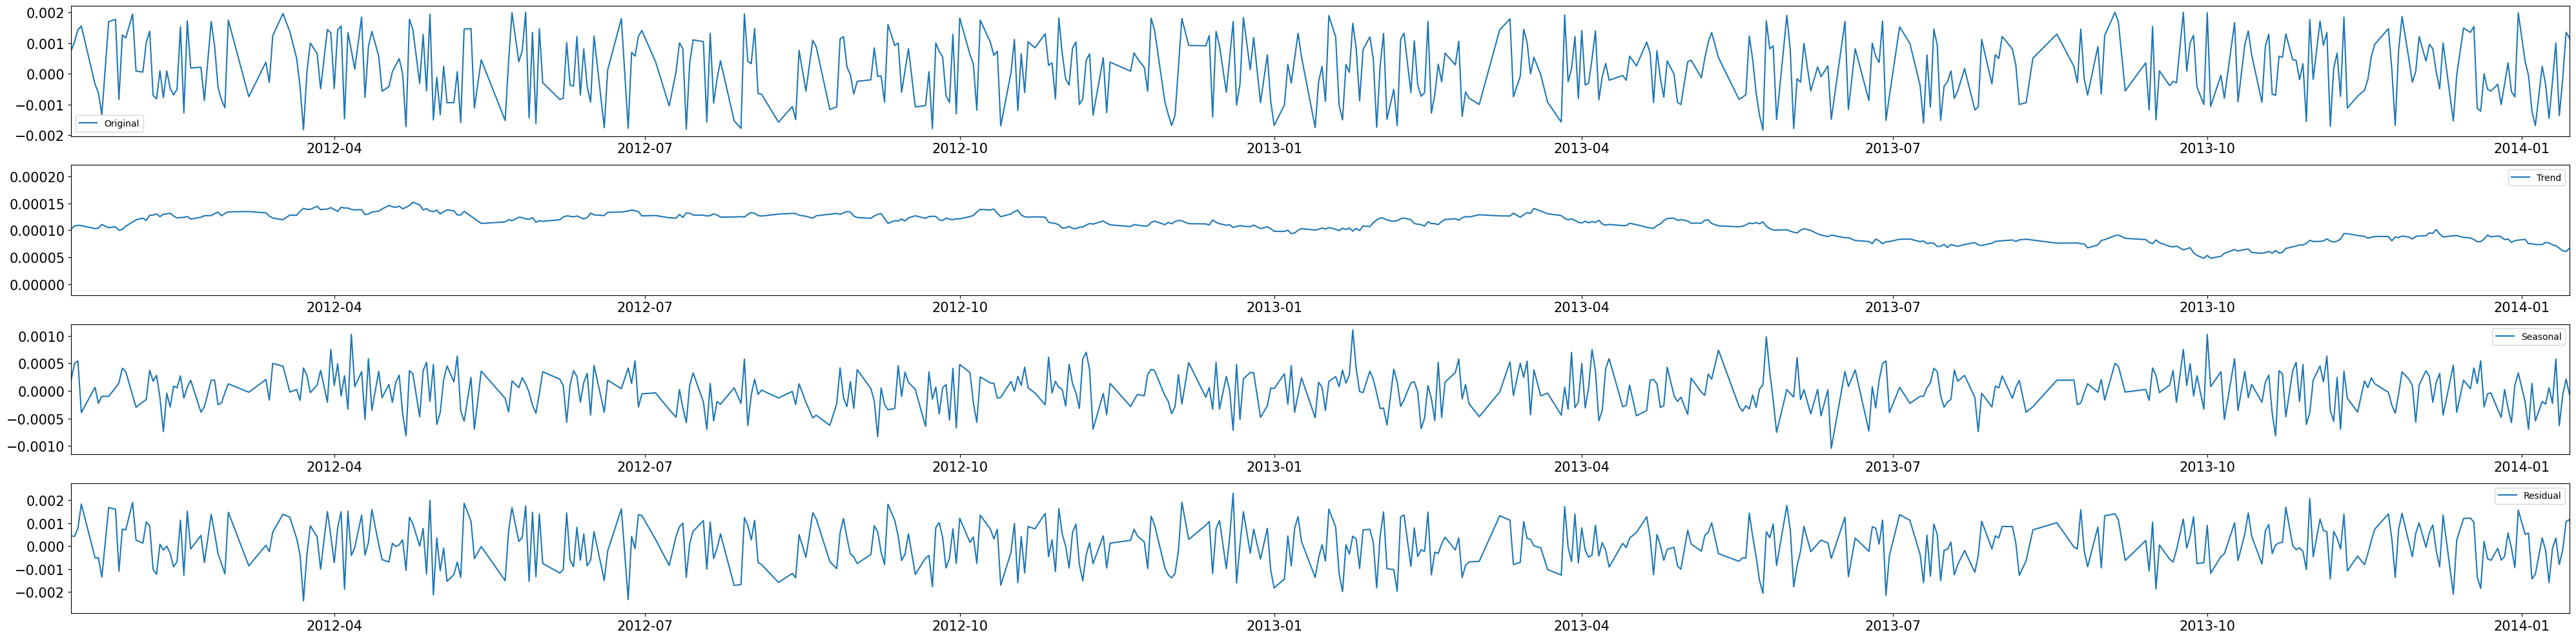

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

#data frame before checking the outliers
decompositionE = seasonal_decompose(tsLogDiffE_noOut, period=365)
trendE = decompositionE.trend
seasonalE = decompositionE.seasonal
residualE = decompositionE.resid

fig=plt.figure(figsize=(40,10))

plt.subplot(411) 
plt.plot(tsLogDiffE_noOut, label='Original') 
plt.legend(loc='best')
plt.xticks(fontsize=15)
plt.xlim(pd.Timestamp('2012-01-15'), pd.Timestamp('2014-01-15'))
plt.yticks(fontsize=15)

plt.subplot(412) 
plt.plot(trendE, label='Trend') 
plt.legend(loc='best') 
plt.xticks(fontsize=15)
plt.xlim(pd.Timestamp('2012-01-15'), pd.Timestamp('2014-01-15'))
plt.yticks(fontsize=15)

plt.subplot(413) 
plt.plot(seasonalE,label='Seasonal') 
plt.legend(loc='best')
plt.xticks(fontsize=15)
plt.xlim(pd.Timestamp('2012-01-15'), pd.Timestamp('2014-01-15'))
plt.yticks(fontsize=15)

plt.subplot(414) 
plt.plot(residualE, label='Residual') 
plt.legend(loc='best') 
plt.xticks(fontsize=15)
plt.xlim(pd.Timestamp('2012-01-15'), pd.Timestamp('2014-01-15'))
plt.yticks(fontsize=15)

plt.tight_layout()

fl = 'pord_decomposition_east_1214.svg'
f = io.BytesIO()
plt.savefig(fl, format="svg")


<Axes: >

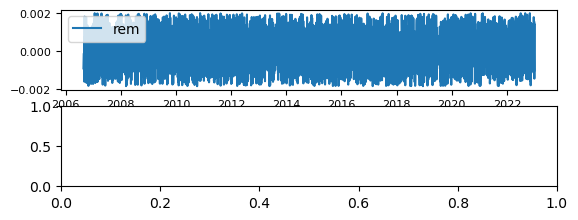

In [20]:
plt.subplot(411) 
plt.plot(tsLogDiffE_noOut, label='rem')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(loc='best') 
plt.subplot(412) 


#data frame with outliers replaced (1086 rows)
decompositionE_outRep = seasonal_decompose(tsLogDiffE_noOut2, period=365)
trendE_outRep = decompositionE_outRep.trend
seasonalE_outRep = decompositionE_outRep.seasonal
residualE_outRep = decompositionE_outRep.resid

plt.subplot(411) 
plt.plot(tsLogDiffE_noOut2, label='Original') 
plt.legend(loc='best') 
plt.subplot(412) 
plt.plot(trendE_outRep, label='T') 
plt.legend(loc='best') 
plt.subplot(413) 
plt.plot(seasonalE_outRep,label='S') 
plt.legend(loc='best') 
plt.subplot(414) 
plt.plot(residualE_outRep, label='R') 
plt.legend(loc='best') 
plt.tight_layout()

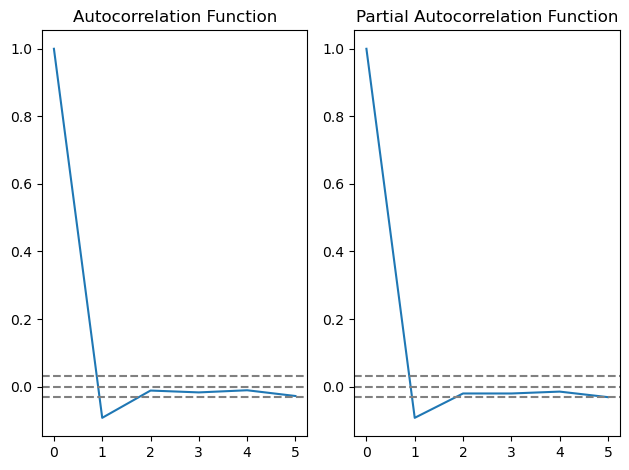

In [21]:
#ACF and PACF plots - rolling mean:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(tsLogDiffE_noOut, nlags=5)
lag_pacf = pacf(tsLogDiffE_noOut, nlags=5, method='ols')

#Plot ACF (q -> model MA): 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(tsLogDiffE_noOut)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(tsLogDiffE_noOut)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF (p -> model AR): 
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(tsLogDiffE_noOut)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(tsLogDiffE_noOut)),linestyle='--',color='gray') 
plt.title('Partial Autocorrelation Function') 
plt.tight_layout()

In [24]:
#converting the index to datetime
tsLogDiffE_df.index = pd.to_datetime(tsLogDiffE_df.index)
#tsLogDiffE_noOut2.index = pd.to_datetime(tsLogDiffE_noOut2.index)
tsLogDiffE_noOut.index = pd.to_datetime(tsLogDiffE_noOut.index)
tsLogE_df.index = pd.to_datetime(tsLogE_df.index)

#making sure that the index is in order
tsLogDiffE_df.sort_index(inplace=True)
#tsLogDiffE_noOut2.sort_index(inplace=True)
tsLogDiffE_noOut.sort_index(inplace=True)
tsLogE_df.sort_index(inplace=True)

#setting the frequency as daily
tsLogDiffE_df = tsLogDiffE_df.asfreq('D')
#tsLogDiffE_noOut2 = tsLogDiffE_noOut2.asfreq('D')
tsLogDiffE_noOut = tsLogDiffE_noOut.asfreq('D')
tsLogE_df = tsLogE_df.asfreq('D')

In [25]:
from statsmodels.tsa.arima.model import ARIMA

In [26]:
tsLogDiffE_df.rename(columns={'__east(m)':'east(m)'}, inplace=True)

In [27]:
print(tsLogDiffE_df['east(m)'])

YYMMMDD
2006-08-26   -0.002526
2006-08-27   -0.000895
2006-08-28    0.003079
2006-08-29   -0.002387
2006-08-30    0.005116
                ...   
2022-12-27    0.001407
2022-12-28   -0.002756
2022-12-29    0.001459
2022-12-30   -0.001436
2022-12-31    0.001525
Freq: D, Name: east(m), Length: 5972, dtype: float64


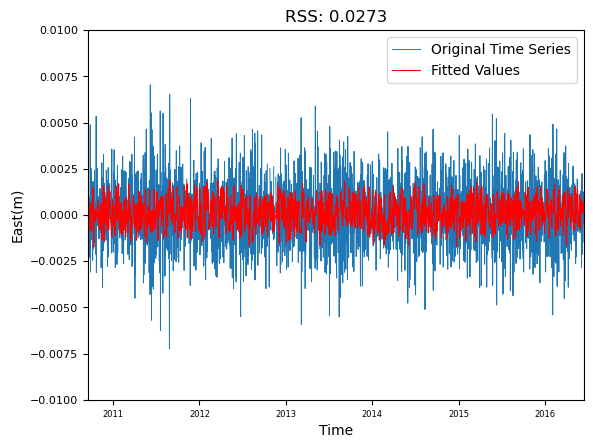

In [28]:
#model AR (Auto-Regressive) -> Plot PACF (p = 1)
modelE_AR = ARIMA(tsLogDiffE_noOut, order=(1, 1, 0))  
resultsE_AR = modelE_AR.fit()
plt.plot(tsLogDiffE_df,  label='Original Time Series', linewidth = 0.7)
plt.plot(resultsE_AR.fittedvalues, color='red', label='Fitted Values', linewidth= 0.8)

# Calculate Residual Sum of Squares (RSS)
residuals_AR = resultsE_AR.fittedvalues - tsLogDiffE_df['east(m)']
rss_AR = np.sum(residuals_AR**2, axis=0)

#Ensure rss is a scalar (float)
#rss_scalar = float(rss.iloc[0]) 

# Show the plot
plt.title(f'RSS: {rss_AR:.4f}')
plt.legend()
plt.xlabel('Time')
plt.xticks(fontsize=6)
plt.xlim(pd.Timestamp('2010-09-15'), pd.Timestamp('2016-06-13'))
plt.ylabel('East(m)')
plt.ylim(-0.01,0.01)
plt.yticks(fontsize=8)
plt.show()

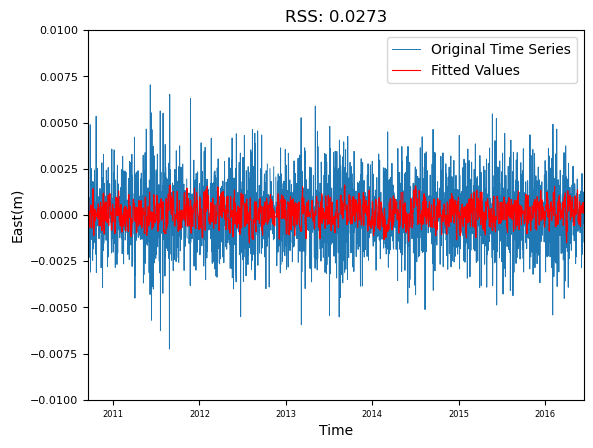

In [29]:
#model MA (Moving Averages) -> Plot ACF (q = 1)
model_MA = ARIMA(tsLogDiffE_noOut, order=(0, 1, 1))  
results_MA = model_MA.fit()  
plt.plot(tsLogDiffE_df, label='Original Time Series', linewidth = 0.7)
plt.plot(results_MA.fittedvalues, color='red', label='Fitted Values', linewidth= 0.8)

# Calculate Residual Sum of Squares (RSS)
residuals_MA = results_MA.fittedvalues - tsLogDiffE_df['east(m)']
rss_MA = np.sum(residuals_MA**2, axis=0)


plt.title(f'RSS: {rss_AR:.4f}')
plt.legend()
plt.xlabel('Time')
plt.xticks(fontsize=6)
plt.xlim(pd.Timestamp('2010-09-15'), pd.Timestamp('2016-06-13'))
plt.ylabel('East(m)')
plt.ylim(-0.01,0.01)
plt.yticks(fontsize=8)
plt.show()

In [31]:
from scipy import interpolate

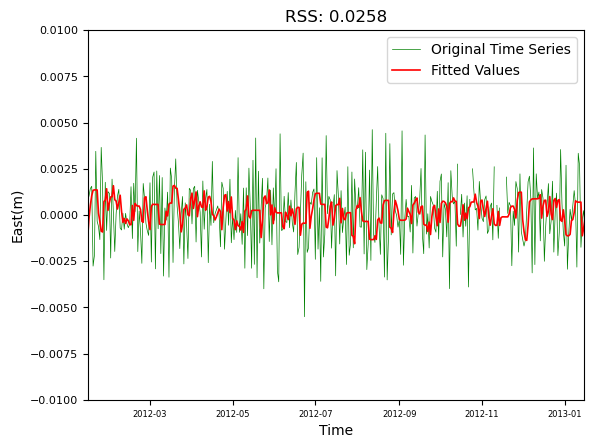

In [32]:
#combined - model ARIMA  p = 1 and q = 1:
#Auto-Regressive Integrated Moving Averages
model_ARIMA = ARIMA(tsLogDiffE_noOut, order=(1, 1, 1))  
results_ARIMA = model_ARIMA.fit()  
plt.plot(tsLogDiffE_df,  color='green', label='Original Time Series', linewidth = 0.5)
plt.plot(results_ARIMA.fittedvalues,color='red', label='Fitted Values', linewidth= 1.2)


# Calculate Residual Sum of Squares (RSS)
residuals_ARIMA = results_ARIMA.fittedvalues - tsLogDiffE_df['east(m)']
rss_ARIMA = np.sum(residuals_ARIMA**2, axis=0)

plt.title(f'RSS: {rss_MA:.4f}')
plt.legend()
plt.xlabel('Time')
plt.xticks(fontsize=6)
plt.xlim(pd.Timestamp('2012-01-15'), pd.Timestamp('2013-01-15'))
plt.ylabel('East(m)')
plt.ylim(-0.010,0.010)
plt.yticks(fontsize=8)
plt.show()

#ARIMA for outlier replaced
model_ARIMA_outDel = ARIMA(tsLogDiffE_noOut2, order=(1, 1, 1))
results_ARIMA_outDel = model_ARIMA_outDel.fit()  

#Plot rep: 
plt.subplot(121) 
plt.plot(tsLogDiffE_df, label='Original Time Series', linewidth = 0.4)
plt.plot(results_ARIMA.fittedvalues, color='red', label='Fitted Values', linewidth= 0.8)
plt.xlim(pd.Timestamp('2010-09-15'), pd.Timestamp('2016-06-13'))
plt.title('Outliers Replaced')

#Plot del: 
plt.subplot(122)
plt.plot(tsLogDiffE_df, label='Original Time Series', linewidth = 0.4)
plt.plot(results_ARIMA_outDel.fittedvalues, color='red', label='Fitted Values', linewidth= 0.8)
plt.xlim(pd.Timestamp('2010-09-15'), pd.Timestamp('2016-06-13'))
plt.title('Outliers Removed')
plt.tight_layout()

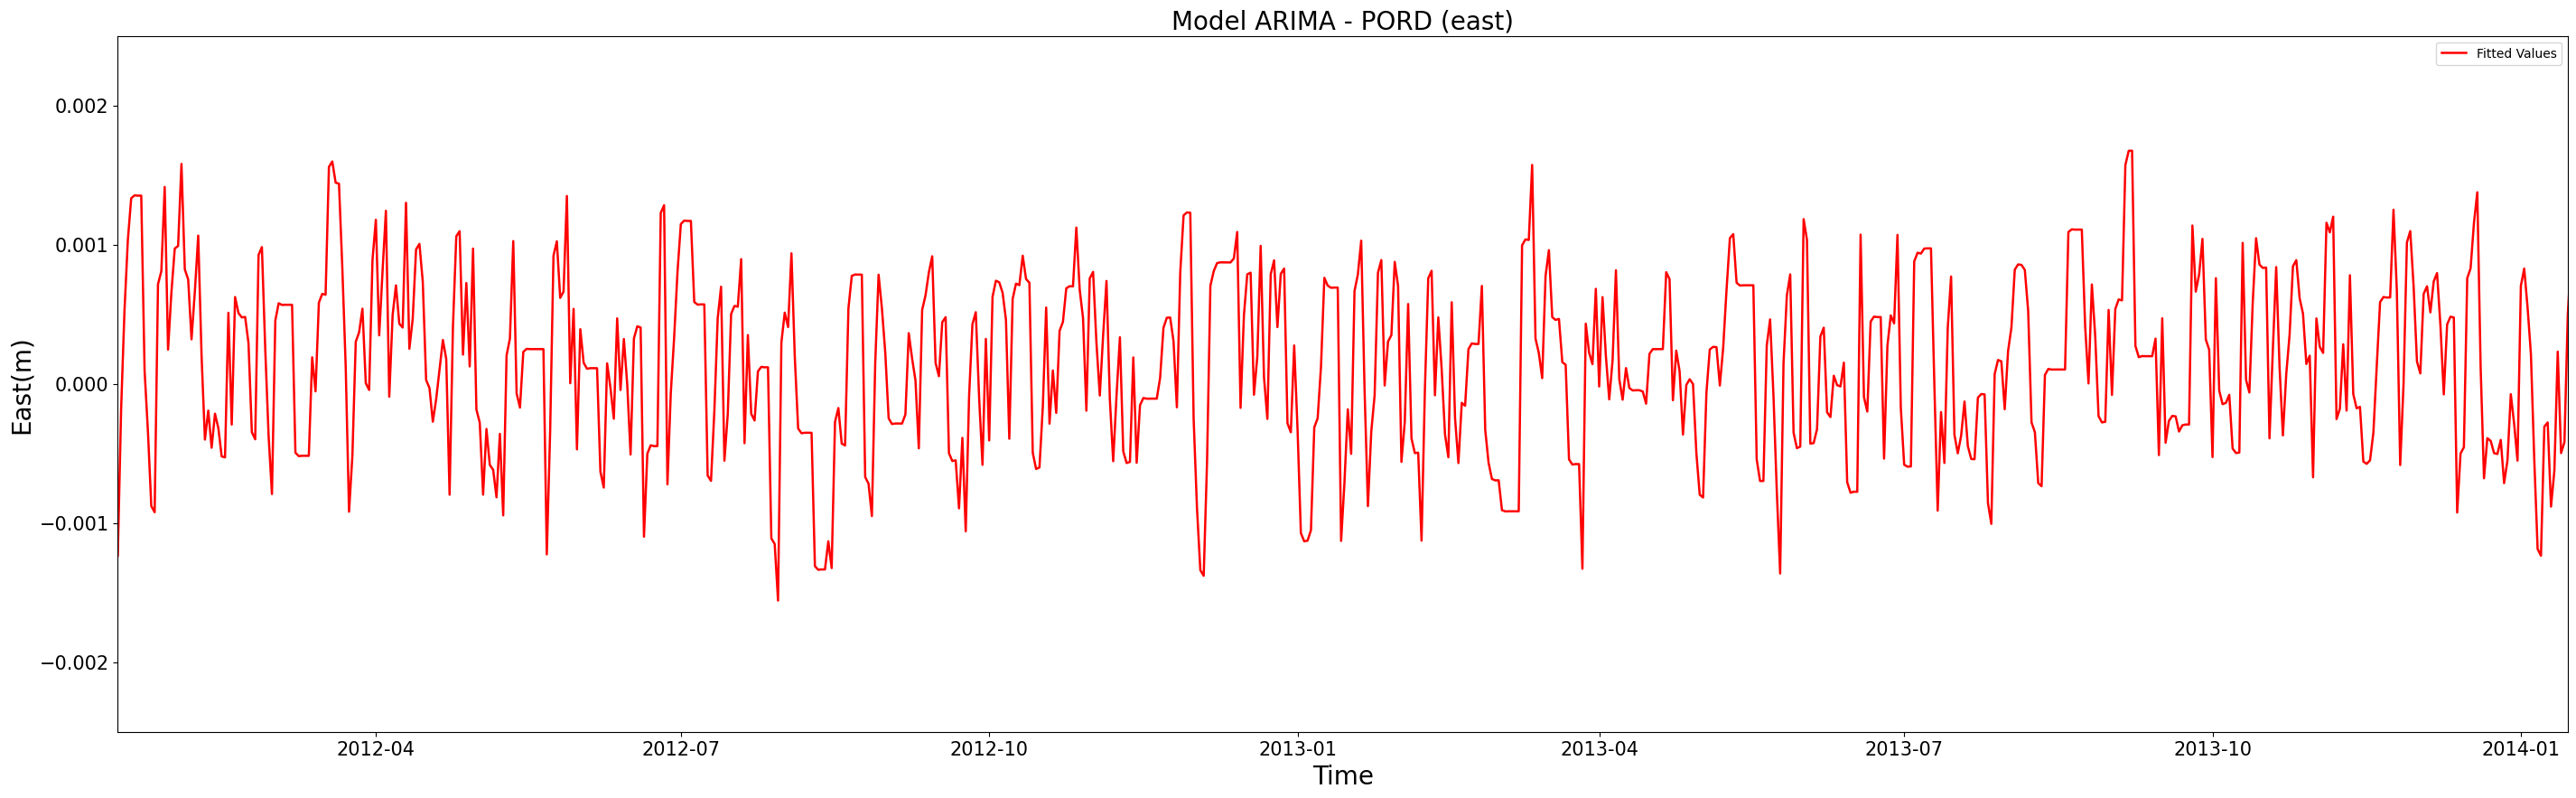

In [33]:
fig=plt.figure(figsize=(35,10))
#plt.plot(tsLogDiffE_df, color='green', label='Original Time Series', linewidth = 1.)
plt.plot(results_ARIMA.fittedvalues, color='red', label='Fitted Values', linewidth = 1.8)

plt.title('Model ARIMA - PORD (east)', fontsize=20)
plt.legend()
plt.xlabel('Time', fontsize=20)
plt.xticks(fontsize=15)
plt.xlim(pd.Timestamp('2012-01-15'), pd.Timestamp('2014-01-15'))
plt.ylabel('East(m)', fontsize=20)
plt.ylim(-0.0025,0.0025)
plt.yticks(fontsize=15)
plt.legend(loc='best') 

fl = 'pord_arima_east.svg'
f = io.BytesIO()
plt.savefig(fl, format="svg")

plt.show()

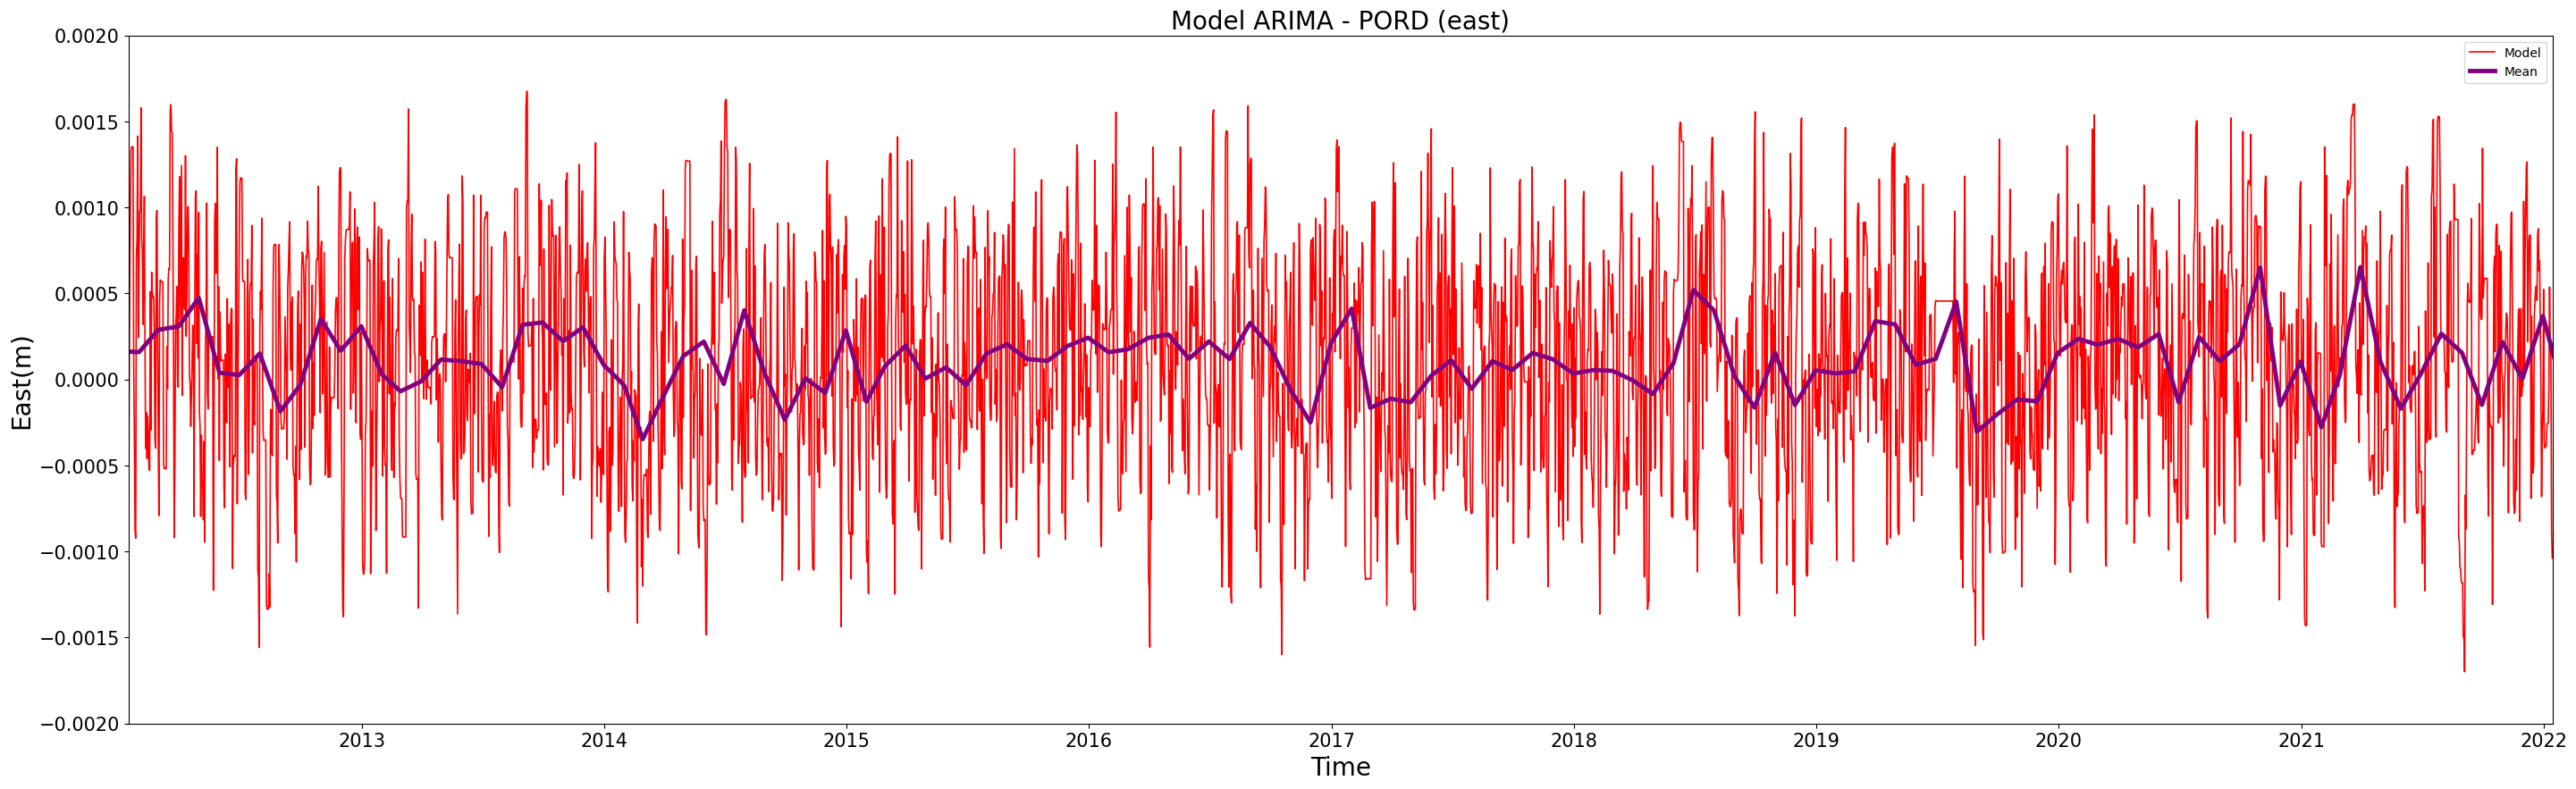

In [34]:
#converting the index to datetime
model = results_ARIMA.fittedvalues
model.index = pd.to_datetime(model.index)

#making sure that the index is in order
model.sort_index(inplace=True)

meanMonth = model.resample('M').mean()


fig=plt.figure(figsize=(35,10))
plt.plot(model, color='red', label='Model', linewidth= 1.2)
plt.plot(meanMonth, color='purple', label='Mean', lw=3.5)
#plt.xlim(pd.Timestamp('2011-12-31'), pd.Timestamp('2014-01-31'))

plt.title('Model ARIMA - PORD (east)', fontsize=20)
plt.legend()
plt.xlabel('Time', fontsize=20)
plt.xticks(fontsize=15)
plt.xlim(pd.Timestamp('2012-01-15'), pd.Timestamp('2022-01-15'))
plt.ylabel('East(m)', fontsize=20)
plt.ylim(-0.002,0.002)
plt.yticks(fontsize=15)

plt.show()